<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/Parallel_CTC_best_result_on_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

import threading
import queue

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'



with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])

max_sequence_len = max(list(map(len, metadata[:, 1])))

# The number of sentences which have wrong labels
error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]


# Wrong label comparison
print(list(metadata[0, 3])) # Correct
print(list(metadata[error_jamos[0], 3])) # Wrong


# Delete wrong data and check the length
print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

# Fix the size of the dataset as a deleted metadata length
dataset_size = len(metadata)

['ᄀ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅫ', 'ᆫ', 'ᄎ', 'ᅡ', 'ᆭ', 'ᄋ', 'ᅳ', 'ᆫ', ' ', 'ᄎ', 'ᅥ', 'ᆨ', 'ᄒ', 'ᅡ', 'ᄅ', 'ᅧ', 'ᄀ', 'ᅩ', ' ', 'ᄋ', 'ᅢ', 'ᄊ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅥ', 'ᆺ', ' ', 'ᄀ', 'ᅡ', 'ᇀ', 'ᄋ', 'ᅡ', 'ᆻ', 'ᄃ', 'ᅡ', '.']
['인', '터', '넷', ' ', '서', '핑', ' ', '중', '이', '에', '요', '.']
(12853, 5)
(12833, 5)


In [0]:
character_length = list() # List of the length of labels
file_length = list() # List of the length of a wav file as sec.
division_length = list() # List of (length of a wav file / length of a label)

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [0]:
wave_name_list = [] # List of wav file names

for data in metadata:
    wave_name_list.append(data[0])

In [6]:
unicode_jamo_list = list() # List of total hanguel jamos + [' ', ',', '<eos>', 'sos', '!', '?', '-']

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode)) # chr: Change hexadecimal to unicode
    
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    

unicode_jamo_list.sort()

# '-' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['-'] + unicode_jamo_list

# Check the symbols
print(unicode_jamo_list)

# Check the total number of symbols
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [0]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
# Create tokenizer, put the whole symbols in and check the output 
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [9]:
# Create mel-spectrogam images from wav files, 
# if mel-spectrogram file already exist, just add their names to the mel_path_list
 
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    # If you have already saved mel-spectrogram, skip mel creating process
    if not os.path.isfile(mel_path):
        
        y, sr = librosa.core.load(wav_path) # I made a mistake... sr=fs
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
#       Sxx = np.maximum(Sxx, eps)

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

        np.save(mel_path, norm_log_mel_specgram)

In [0]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
         
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
                
        
        # (B, T, H)
        
        output_tensor, _ = self.gru(output_tensor)
        
        # (B, T, 2 * H/2)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        
        
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        # Use GPU if GPU is available 
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)

        self.ctc_loss = nn.CTCLoss().to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)
        
        # Calculate loss
        loss.backward()

        # Update weights
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    
    def test(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        
    def set_mode(self, mode):
        
        # Must call .train() after loading if you want to train again
        if mode == 'train':
            self.encoder.train()
            self.decoder.train()
        
        # Must call .eval() after loading if you do not want to use dropouts
        elif mode == 'eval':
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
class Threading_Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Threading_Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = False
        self.batch_size = batch_size
        self.queue = queue.Queue()
        self.thread_flags = list()
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self, thread_num):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])

        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        loading_sequence_len = len(loading_sequence)
        thread_size = int(np.ceil(loading_sequence_len / thread_num))

        load_idxs_list = list()
        for i in range(thread_num):
            start_idx = i * thread_size
            end_idx = (i + 1) * thread_size

            if end_idx > loading_sequence_len:
                end_idx = loading_sequence_len

            load_idxs_list.append(loading_sequence[start_idx:end_idx])

        self.end_flag = False
        
        self.queue = queue.Queue()
        self.thread_flags = [False] * thread_num
        
        self.thread_list = [Batching_Thread(self.mel_path_list, self.ground_truth_list, load_idxs_list[i], self.queue, self.batch_size, self.thread_flags, i) for i in range(thread_num)]

        for thread in self.thread_list:
            thread.start()

        return

    def check_thread_flags(self):
        for flag in self.thread_flags:
            if flag == False:
                return False
        
        if (self.queue.empty):
            self.end_flag = True
            return True

        return False

    def get_batch(self):
        while not (self.check_thread_flags()):
            batch = self.queue.get()

            if (batch != None):
                batched_tensor = batch[0]
                batched_ground_truth = batch[1] 
                batched_loss_mask = batch[2]
                ground_truth_size_list = batch[3]

                return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list

        return None

class Batching_Thread(threading.Thread):

    def __init__(self, mel_path_list, ground_truth_list, load_idxs_list, queue, batch_size, thread_flags, id):
        
        threading.Thread.__init__(self)
        self.mel_path_list = mel_path_list
        self.ground_truth_list = ground_truth_list
        self.load_idxs_list = load_idxs_list
        self.list_len = len(load_idxs_list)
        self.cur_idx = 0
        self.id = id
        self.queue = queue
        self.batch_size = batch_size 
        self.thread_flags = thread_flags

    def run(self):

        while(self.cur_idx < self.list_len):
            batch = self.batch()
            self.queue.put(batch)

        self.thread_flags[self.id] = True

        return 

    def batch(self):

        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.cur_idx >= self.list_len:
                self.end_flag = True
                break
            
            mel_path = self.mel_path_list[self.load_idxs_list[self.cur_idx]]

            tensor = self.load_mel(mel_path)
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.load_idxs_list[self.cur_idx]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.cur_idx += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            # pad_random = np.random.randint(0, 5)
            
            # # Time shift, add zeros in front of an image
            # if pad_random > 0:
            #     offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
            #     target = torch.cat((offset, target), 1)
            
            # # Add random noise
            # target = target + (torch.rand(target.shape) - 0.5) / 20
        
            # # Value less than 0 or more than 1 is clamped to 0 and 1
            # target = torch.clamp(target, min=0.0, max=1.0)
            
            # batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target

            batched_tensor[order, :tensor_size_list[order], :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return [batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list]

    def load_mel(self, mel_path):
        norm_log_mel_specgram = np.load(mel_path)
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        return tensor_input


In [0]:
# Create true sentence list, <eos> is added to the end
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [14]:
print(len(mel_path_list))

print(len(ground_truth_list))

# 80% of the data will be used as train
split_index = int(0.8 * len(mel_path_list))

# Split index is the number stands for 80%
print(split_index)

# Split index is the number stands for 80%
mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_eval = mel_path_list[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]

print(len(mel_path_list_eval))

12833
12833
10266
10266
2567


In [0]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

preloader_eval = Threading_Batched_Preloader(mel_path_list_eval, ground_truth_list_eval, 64)

preloader_train = Threading_Batched_Preloader(mel_path_list_train, ground_truth_list_train, 64)

In [0]:
# preloader_train.initialize_batch(16)

# counter = 0
# while preloader_train.end_flag == False:

#     batch = preloader_train.get_batch()
#     if batch != None:
#         tensor_input, ground_truth, loss_mask, length_list = batch

#         print(tensor_input.shape)

#     counter += 1

#     print(counter)

In [0]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

09-13 14:37:04
Mean Train Loss: 0.059667225317663
Mean Evaluation Loss: 0.06319153184602479
-------------------------------------------------------------------------------------------------------
09-13 14:52:00
Mean Train Loss: 0.06090425859336876
Mean Evaluation Loss: 0.05818334295906669
-------------------------------------------------------------------------------------------------------
09-13 14:52:18
Mean Train Loss: 0.05884006044832102
Mean Evaluation Loss: 0.056611860489541824
-------------------------------------------------------------------------------------------------------
09-13 14:52:36
Mean Train Loss: 0.057330826529796174
Mean Evaluation Loss: 0.056983397456655135
-------------------------------------------------------------------------------------------------------
09-13 14:52:53
Mean Train Loss: 0.05624732142756692
Mean Evaluation Loss: 0.05332285039239584
-------------------------------------------------------------------------------------------------------
09-13 14:

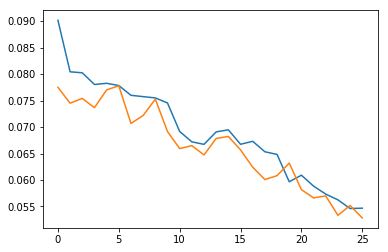

지----------- 이-사-사-아-이-이 자-아-아-압니---ᄃ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
지 이사사아이이 자아아압니다.<eos>
지금 제 상황이 절박합니다.<eos>---


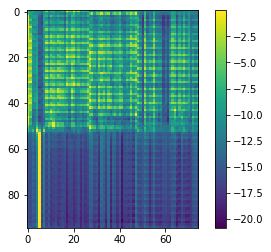

지---------ᄋᆫ 이-이 아-아-은-ᆫ 마-이-디-다 다-지-이 -ᅵ-이 다-ᄋ-------ᅡᅡ.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
지ᄋᆫ 이이 아아은ᆫ 마이디다 다지이 ᅵ이 다아.<eos>
신호등이 파란 불로 바뀔 때까지 기다려라.<eos>--


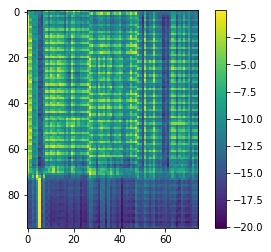

-------------------------------------------------------------------------------------------------------
09-13 14:53:46
Mean Train Loss: 0.05245971620523057
Mean Evaluation Loss: 0.050556934193008454
-------------------------------------------------------------------------------------------------------
09-13 14:54:03
Mean Train Loss: 0.05068553412408477
Mean Evaluation Loss: 0.05005381869436602
-------------------------------------------------------------------------------------------------------
09-13 14:54:21
Mean Train Loss: 0.04932062151819869
Mean Evaluation Loss: 0.04949515332410008
-------------------------------------------------------------------------------------------------------
09-13 14:54:38
Mean Train Loss: 0.04718435993198403
Mean Evaluation Loss: 0.047734531522548695
-------------------------------------------------------------------------------------------------------
09-13 14:54:56
Mean Train Loss: 0.047211345526368735
Mean Evaluation Loss: 0.047158396280889685
------

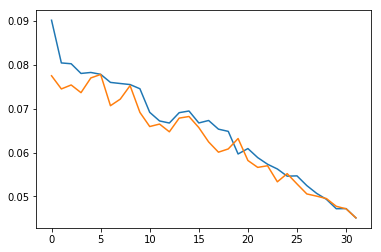

이----------------- 제-ᄋᆫ 전에 에 언우른 건두-르른 부-르-이 서-십습니---다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이 제ᄋᆫ 전에 에 언우른 건두르른 부르이 서십습니다.<eos>
일주일 전에 제 원고의 검토를 의뢰했었습니다.<eos>-----


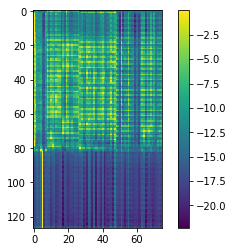

수------사-ᅳᆫ - -저-아--ᆫ 이-하-아ᄂ은   이-시-입니---다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
수사ᅳᆫ  저안 이하아ᄂ은 이시입니다.<eos>
제사는 조상을 기념하는 의식입니다.<eos>------


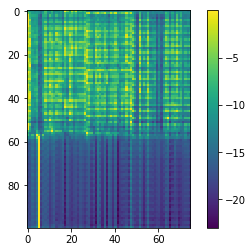

-------------------------------------------------------------------------------------------------------
09-13 14:55:33
Mean Train Loss: 0.045164551899053045
Mean Evaluation Loss: 0.044697716843198856
-------------------------------------------------------------------------------------------------------
09-13 14:55:50
Mean Train Loss: 0.043122999355453114
Mean Evaluation Loss: 0.04324783450542625
-------------------------------------------------------------------------------------------------------
09-13 14:56:08
Mean Train Loss: 0.042489809008177615
Mean Evaluation Loss: 0.042270236810936
-------------------------------------------------------------------------------------------------------
09-13 14:56:25
Mean Train Loss: 0.04084484114581167
Mean Evaluation Loss: 0.0430044005909903
-------------------------------------------------------------------------------------------------------
09-13 14:56:44
Mean Train Loss: 0.0399801959984414
Mean Evaluation Loss: 0.04056402853740561
----------

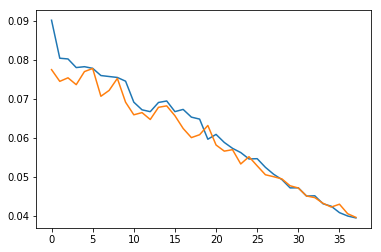

어--------ᆷ므른 따-ᅡᅡ르ᅳᄅ-  잘---지-세---요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
엄므른 따ᅡ르ᄅ 잘지세요.<eos>
엄마는 피아노를 잘 치세요.<eos>-----


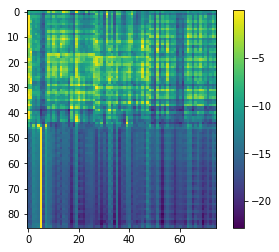

하--------------ᆫ곡   다ᅡᅡᅡ-바-ᅡᅡ ᄌ  줌고 에ᄉ서 구-르-ᅳᅳ ᄉᄉᄉ사ᄅ리를 이ᄅ오 하-고 있어----요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
한곡 다바ᅡ ᄌ 줌고 에서 구르ᅳ 사리를 이ᄅ오 하고 있어요.<eos>
한국 드라마가 중국에서 높은 시청률을 기록하고 있어요.<eos>-------------------------


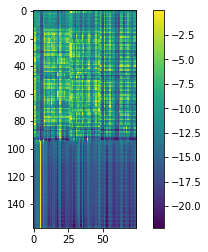

-------------------------------------------------------------------------------------------------------
09-13 14:57:20
Mean Train Loss: 0.03856822381835452
Mean Evaluation Loss: 0.03848453676479418
-------------------------------------------------------------------------------------------------------
09-13 14:57:37
Mean Train Loss: 0.037083604368208484
Mean Evaluation Loss: 0.03780173124050942
-------------------------------------------------------------------------------------------------------
09-13 14:57:55
Mean Train Loss: 0.03632719760749011
Mean Evaluation Loss: 0.039293076649860086
-------------------------------------------------------------------------------------------------------
09-13 14:58:13
Mean Train Loss: 0.03703693384752065
Mean Evaluation Loss: 0.037196891289116116
-------------------------------------------------------------------------------------------------------
09-13 14:58:30
Mean Train Loss: 0.03463210848931571
Mean Evaluation Loss: 0.03505489368651741
-------

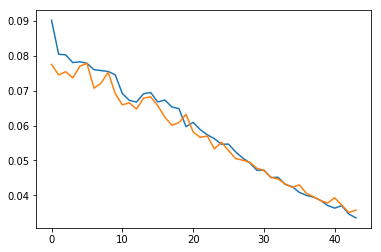

어느ᅵᄌ조 ᄀ굴-한---만------져.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
어느ᅵ조 굴한만져.<eos>
머리 좀 그만 만져.<eos>--


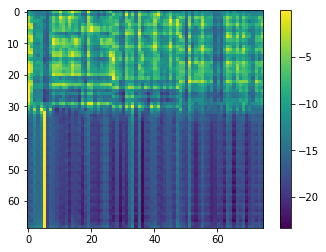

사-----------각시ᅵ  디이기ᅵᆯ드를 보--ᆯ-란ᆫ 모ᅩᄋᄋ -없을-----까?<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
사각시 디이길드를 볼란 모ᄋ 없을까?<eos>
싼값에 비행기 표를 구할 방법 없을까?<eos>--


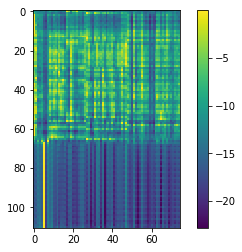

-------------------------------------------------------------------------------------------------------
09-13 14:59:06
Mean Train Loss: 0.03281527567176787
Mean Evaluation Loss: 0.03413197089238195
-------------------------------------------------------------------------------------------------------
09-13 14:59:24
Mean Train Loss: 0.03230236138379681
Mean Evaluation Loss: 0.03192238566102391
-------------------------------------------------------------------------------------------------------
09-13 14:59:42
Mean Train Loss: 0.031123999025483896
Mean Evaluation Loss: 0.0316057641788784
-------------------------------------------------------------------------------------------------------
09-13 15:00:00
Mean Train Loss: 0.03072226283033515
Mean Evaluation Loss: 0.03234015354740492
-------------------------------------------------------------------------------------------------------
09-13 15:00:18
Mean Train Loss: 0.030506871994892305
Mean Evaluation Loss: 0.031238199012215223
--------

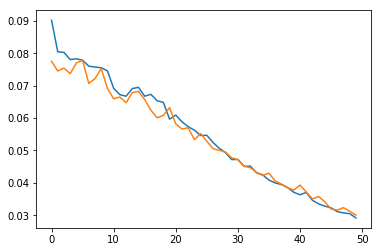

우----------------------ᄅ리른  간치-가ᄂ은 차인 때-ᄆ무-에--  느--허-졌ᆻ어ᅥᅥ-요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우리른 간치가ᄂ은 차인 때무에 느허졌어요.<eos>
우리는 가치관의 차이 때문에 헤어졌어요.<eos>----


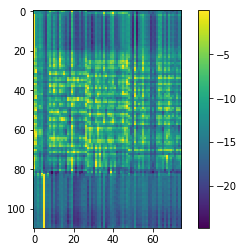

이---------------세-일에  치-들 ᅡᅡ히ᅵ를해-ᄐ되-고ᅩ 있습니---다..<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이세일에 치들 ᅡ히를해ᄐ되고 있습니다.<eos>
이 책은 십 프로 할인을 해 드리고 있습니다.<eos>---------


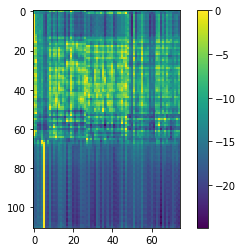

-------------------------------------------------------------------------------------------------------
09-13 15:00:54
Mean Train Loss: 0.027939164439938595
Mean Evaluation Loss: 0.029508458419041726
-------------------------------------------------------------------------------------------------------
09-13 15:01:12
Mean Train Loss: 0.027646083246831255
Mean Evaluation Loss: 0.02894085424907957
-------------------------------------------------------------------------------------------------------
09-13 15:01:31
Mean Train Loss: 0.02753643190176499
Mean Evaluation Loss: 0.029390122559355542
-------------------------------------------------------------------------------------------------------
09-13 15:01:48
Mean Train Loss: 0.02627146169057504
Mean Evaluation Loss: 0.027424871042362495
-------------------------------------------------------------------------------------------------------
09-13 15:02:06
Mean Train Loss: 0.02612721026698467
Mean Evaluation Loss: 0.027985842121332736
----

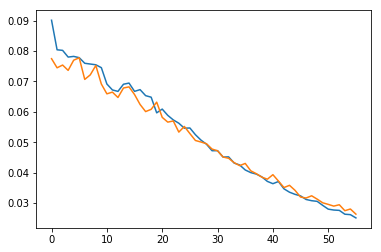

시---------------ᆫ 주-정ᄋ이 경무- 부--두ᄋᄋ----  제-- 시-시-을  내-든 ᅡᅡ다ᅡᄀ고 ᄉ싶어---요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
신 주정이 경무 부두ᄋ 제 시시을 내든 ᅡ다고 싶어요.<eos>
실질적인 경험을 통해 제 지식을 넓혀 나가고 싶어요.<eos>---------


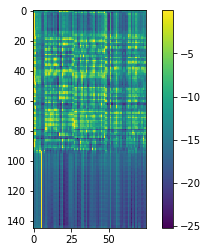

저--------는 서 얼에ᄉ서 대ᄒ하-핱-짐만-- 그-사-라ᅦ 서 달-았어----요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저는 서 얼에서 대하핱짐만 그사라ᅦ 서 달았어요.<eos>
저는 서울에서 태어났지만 부산에서 자랐어요.<eos>----------


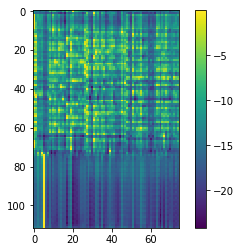

-------------------------------------------------------------------------------------------------------
09-13 15:02:42
Mean Train Loss: 0.024848709742955208
Mean Evaluation Loss: 0.026889329192079144
-------------------------------------------------------------------------------------------------------
09-13 15:03:00
Mean Train Loss: 0.02548567048942172
Mean Evaluation Loss: 0.026186923074315097
-------------------------------------------------------------------------------------------------------
09-13 15:03:18
Mean Train Loss: 0.024492219995333193
Mean Evaluation Loss: 0.027082709674594658
-------------------------------------------------------------------------------------------------------
09-13 15:03:36
Mean Train Loss: 0.023856651746886587
Mean Evaluation Loss: 0.02679964551559101
-------------------------------------------------------------------------------------------------------
09-13 15:03:53
Mean Train Loss: 0.022892889499994667
Mean Evaluation Loss: 0.025501733292712426
--

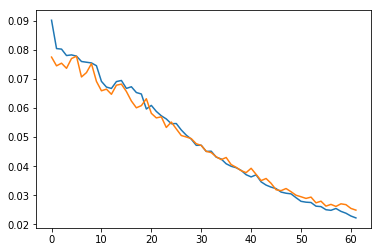

새-----------------ᅳᆯᆯ ᅵᅢ-갱  위-으ᄅ로--  다-식 ᅥ-은 이-를지 못-했ᆻ어--요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
새ᅳᆯ ᅵᅢ갱 위으로 다식 ᅥ은 이를지 못했어요.<eos>
새벽에 깬 이후로 다시 잠을 이루지 못했어요.<eos>----------


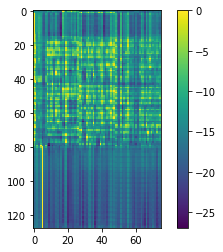

내--------------- 기-슬 서ᅥ  ᅦ  몰ᅳᆯ 가-저ᅩ-와-야-해--요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
내 기슬 서 ᅦ 몰ᅳᆯ 가저ᅩ와야해요.<eos>
내일 미술 수업에 뭘 가져와야 해요?<eos>---------


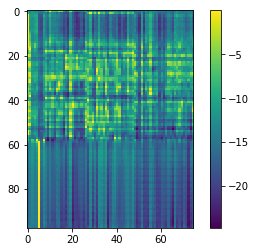

-------------------------------------------------------------------------------------------------------
09-13 15:04:29
Mean Train Loss: 0.02282916016792959
Mean Evaluation Loss: 0.025642247166100997
-------------------------------------------------------------------------------------------------------
09-13 15:04:47
Mean Train Loss: 0.022310273230358228
Mean Evaluation Loss: 0.025662835553670542
-------------------------------------------------------------------------------------------------------
09-13 15:05:04
Mean Train Loss: 0.021717063333775034
Mean Evaluation Loss: 0.02610388916601287
-------------------------------------------------------------------------------------------------------
09-13 15:05:22
Mean Train Loss: 0.021664088630614847
Mean Evaluation Loss: 0.02549218419961329
-------------------------------------------------------------------------------------------------------
09-13 15:05:40
Mean Train Loss: 0.021040068857364314
Mean Evaluation Loss: 0.024106787537284548
---

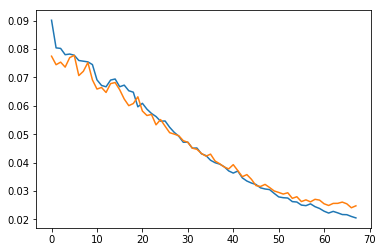

하----------------ᆫ 순-간ᄋ의 부-ᄌ주-이-가--  치--현-전인 사ᅡ-골을  여-기-갈 실- 있습니ᅵ--다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
한 순간의 부주이가 치현전인 사골을 여기갈 실 있습니다.<eos>
한순간의 부주의가 치명적인 사고를 야기할 수도 있습니다.<eos>-----


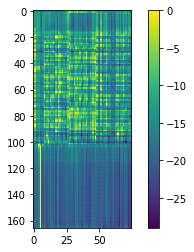

오---------느ᅳᆫ  몸이 안  좋아---ᄋ요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
오는 몸이 안 좋아요.<eos>
오늘 몸이 안 좋아요.<eos>-----------


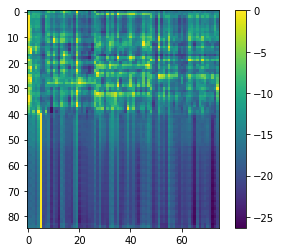

-------------------------------------------------------------------------------------------------------
09-13 15:06:17
Mean Train Loss: 0.02068984431861751
Mean Evaluation Loss: 0.024712899143416848
-------------------------------------------------------------------------------------------------------
09-13 15:06:34
Mean Train Loss: 0.020306494047909383
Mean Evaluation Loss: 0.023972249443423018
-------------------------------------------------------------------------------------------------------
09-13 15:06:53
Mean Train Loss: 0.020137881067801695
Mean Evaluation Loss: 0.024221025145330408
-------------------------------------------------------------------------------------------------------
09-13 15:07:11
Mean Train Loss: 0.020929505795339313
Mean Evaluation Loss: 0.02495757362077809
-------------------------------------------------------------------------------------------------------
09-13 15:07:28
Mean Train Loss: 0.02149240964065123
Mean Evaluation Loss: 0.024391082051850147
---

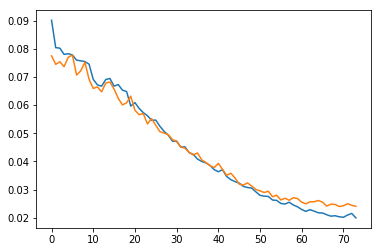

어----------------ᆷᄆ마-는에 구-사ᄅ랑한-제-  그--게  몽주--일괴-아-세ᅦ-ᄋ요?<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
엄마는에 구사랑한제 그게 몽주일괴아세요?<eos>
엄마는 왜 그 사람한테 그렇게 모질게 대하세요?<eos>-------


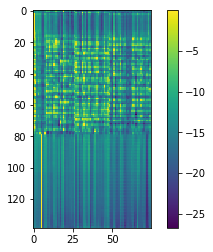

저-----------ᅴ 십-다-에ᄉ서-는 우-식ᄋ에 종이ᄅᄅᄅ를 맣지ᅵ 않-습니--ᄃ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저ᅴ 십다에서는 우식에 종이를 맣지 않습니다.<eos>
저희 식당에서는 음식에 조미료를 넣지 않습니다.<eos>----


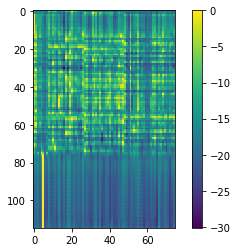

-------------------------------------------------------------------------------------------------------
09-13 15:08:05
Mean Train Loss: 0.019105089333233235
Mean Evaluation Loss: 0.023565078223612455
-------------------------------------------------------------------------------------------------------
09-13 15:08:22
Mean Train Loss: 0.018332028852523958
Mean Evaluation Loss: 0.022494159501521775
-------------------------------------------------------------------------------------------------------
09-13 15:08:40
Mean Train Loss: 0.022318074485542353
Mean Evaluation Loss: 0.024585635248041585
-------------------------------------------------------------------------------------------------------
09-13 15:08:58
Mean Train Loss: 0.020776949442900813
Mean Evaluation Loss: 0.02413522767059969
-------------------------------------------------------------------------------------------------------
09-13 15:09:16
Mean Train Loss: 0.01955148029213469
Mean Evaluation Loss: 0.023034510844864232
--

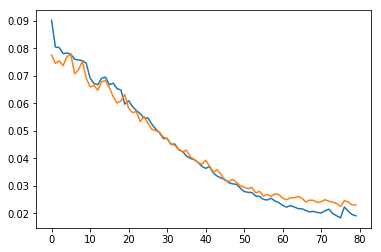

어-------더ᄃ으  그ᄅ어-게  구-표--가ᄉ세-요ᅭ?<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
어더ᄃ으 그ᄅ어게 구표가세요?<eos>
어디를 그렇게 급히 가세요?<eos>------


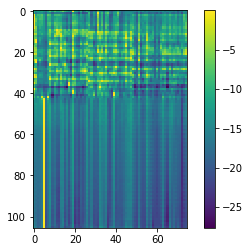

이------------- 자-역은ᆫ  발람인-세-고ᅩ----- ᄌᄌ--트- ᅡᅡ기-든 기는ᆫ 나-이  많ᄋ아--ᄋ요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이 자역은 발람인세고 ᄌ트 ᅡ기든 기는 나이 많아요.<eos>
이 지역은 바람이 세고 짙은 안개가 끼는 날이 많아요.<eos>-----------


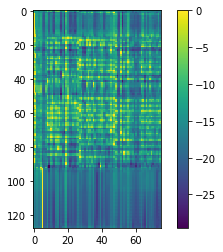

-------------------------------------------------------------------------------------------------------
09-13 15:09:52
Mean Train Loss: 0.018528061862325876
Mean Evaluation Loss: 0.021502773028103273
-------------------------------------------------------------------------------------------------------
09-13 15:10:10
Mean Train Loss: 0.01884093313042076
Mean Evaluation Loss: 0.023565698226635484
-------------------------------------------------------------------------------------------------------
09-13 15:10:28
Mean Train Loss: 0.018033711218522108
Mean Evaluation Loss: 0.02270119947263564
-------------------------------------------------------------------------------------------------------
09-13 15:10:45
Mean Train Loss: 0.017576738699468603
Mean Evaluation Loss: 0.02236332929305313
-------------------------------------------------------------------------------------------------------
09-13 15:11:05
Mean Train Loss: 0.017808649747030572
Mean Evaluation Loss: 0.02233793217529449
----

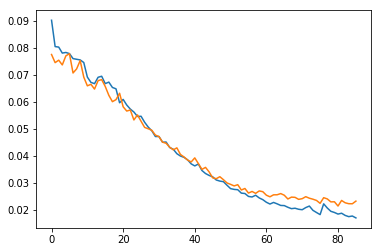

혀------------------ᆨ졍의  자-시ᄒ한 내-움은--  아-직 갈-개-리-지 아ᅡᆭ았습니--다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
혁졍의 자시한 내움은 아직 갈개리지 않았습니다.<eos>
협정의 자세한 내용은 아직 발표되지 않았습니다.<eos>---


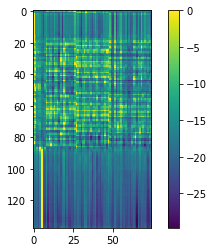

새----------------런애한 그-여-와ᅪ-----  대--게 ᄇ모ᄀ고 싶ᇁ----어.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
새런애한 그여와 대게 ᄇ모고 싶어.<eos>
새로 나온 그 영화 되게 보고 싶어.<eos>-----------


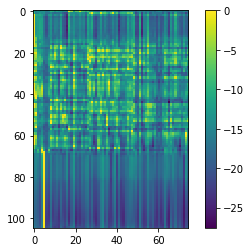

-------------------------------------------------------------------------------------------------------
09-13 15:11:41
Mean Train Loss: 0.016833783640287852
Mean Evaluation Loss: 0.021649878940139065
-------------------------------------------------------------------------------------------------------
09-13 15:11:59
Mean Train Loss: 0.016271238388901633
Mean Evaluation Loss: 0.021190958041502304
-------------------------------------------------------------------------------------------------------
09-13 15:12:17
Mean Train Loss: 0.017188045764304494
Mean Evaluation Loss: 0.023218593270891492
-------------------------------------------------------------------------------------------------------
09-13 15:12:35
Mean Train Loss: 0.017342541620517092
Mean Evaluation Loss: 0.021904255835616747
-------------------------------------------------------------------------------------------------------
09-13 15:12:53
Mean Train Loss: 0.01593113414700863
Mean Evaluation Loss: 0.020691236757396612
-

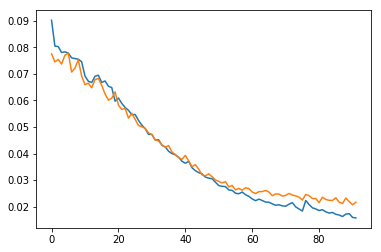

지-하-천에-서-는-----  신-부-을ᄑᄑᆯᆯ 치-고- 버-서ᄂ는-  안---든---다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
지하천에서는 신부을ᄑᆯ 치고 버서는 안든다.<eos>
지하철에서는 신문을 펼치고 봐서는 안 된다.<eos>--------


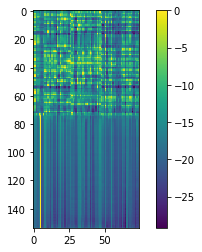

마--------------ᆫ이 ᄉ십세  이-상이-면ᆫ 누-군아  가익ᆨ할 수 ᄋ있습니-다..<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
만이 십세 이상이면 누군아 가익할 수 있습니다.<eos>
만 이십 세 이상이면 누구나 가입할 수 있습니다.<eos>-----


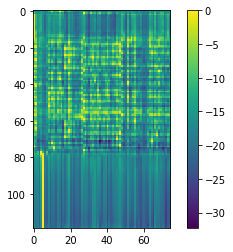

-------------------------------------------------------------------------------------------------------
09-13 15:13:30
Mean Train Loss: 0.015546825933766517
Mean Evaluation Loss: 0.021483659766180437
-------------------------------------------------------------------------------------------------------
09-13 15:13:47
Mean Train Loss: 0.01599310628495431
Mean Evaluation Loss: 0.021551654724248834
-------------------------------------------------------------------------------------------------------
09-13 15:14:05
Mean Train Loss: 0.015203240964112097
Mean Evaluation Loss: 0.021308906234668353
-------------------------------------------------------------------------------------------------------
09-13 15:14:24
Mean Train Loss: 0.02039697430485961
Mean Evaluation Loss: 0.022648165309982933
-------------------------------------------------------------------------------------------------------
09-13 15:14:41
Mean Train Loss: 0.021462410197115745
Mean Evaluation Loss: 0.023160183657067714
--

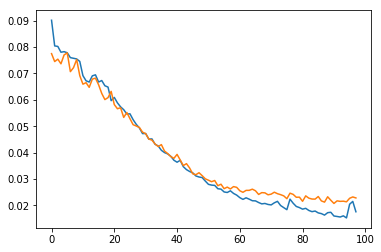

왜--------------  나-ᅳᅳᆫ 근양후 심마--서-  뚜은ᄐ탁에 숙기를 아ᅡᆫᄃᄃ-는 거--야?<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
왜 나ᅳᆫ 근양후 심마서 뚜은탁에 숙기를 안ᄃ는 거야?<eos>
왜 나는 그냥 쉬면서 느긋하게 즐기면 안 되는 거야?<eos>--


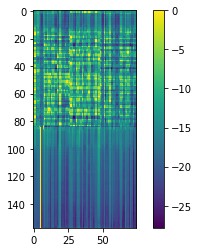

저-----------------는 ᄋ악제--가-  두-자-가 달거-라ᄂ으  피방을 폭ᄀ고 이ᅵᆻ어-요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저는 악제가 두자가 달거라ᄂ으 피방을 폭고 있어요.<eos>
저는 언젠가 부자가 될 거라는 희망을 품고 있어요.<eos>--


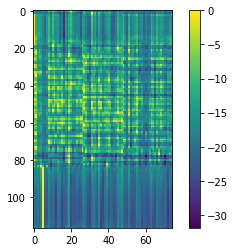

-------------------------------------------------------------------------------------------------------
09-13 15:15:18
Mean Train Loss: 0.016721207804352163
Mean Evaluation Loss: 0.02241969830253475
-------------------------------------------------------------------------------------------------------
09-13 15:15:36
Mean Train Loss: 0.016408018874675044
Mean Evaluation Loss: 0.021806353700184633
-------------------------------------------------------------------------------------------------------
09-13 15:15:54
Mean Train Loss: 0.016695080765058472
Mean Evaluation Loss: 0.0213658259714131
-------------------------------------------------------------------------------------------------------
09-13 15:16:12
Mean Train Loss: 0.015611382275856595
Mean Evaluation Loss: 0.021060711669430444
-------------------------------------------------------------------------------------------------------
09-13 15:16:30
Mean Train Loss: 0.01500507422607088
Mean Evaluation Loss: 0.021043294599667348
----

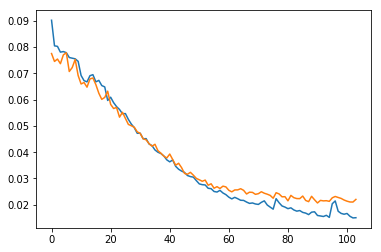

제-----------------------가  바-ᆯᆯᆫ단-네은 실ᆯᆯ 수ᄅᄅᆯᆯ 했어ᅥ-ᄋ요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
제가 발ᆫ단네은 실 수ᄅᆯ 했어요.<eos>
제가 말도 안 되는 실수를 했어요.<eos>---------


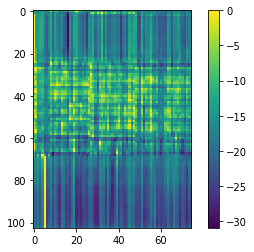

나-------------ᄂ는ᆫ--  버-에 브-덯은 거짓-말일 지---쳤ᆻ--어.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
나는 버에 브덯은 거짓말일 지쳤어.<eos>
나는 너의 끝없는 거짓말에 지쳤어.<eos>-------


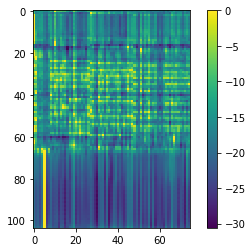

-------------------------------------------------------------------------------------------------------
09-13 15:17:07
Mean Train Loss: 0.01564216839327643
Mean Evaluation Loss: 0.023530073655994233
-------------------------------------------------------------------------------------------------------
09-13 15:17:25
Mean Train Loss: 0.016386999869186066
Mean Evaluation Loss: 0.022138824029546256
-------------------------------------------------------------------------------------------------------
09-13 15:17:43
Mean Train Loss: 0.015120639675253008
Mean Evaluation Loss: 0.020793876219726247
-------------------------------------------------------------------------------------------------------
09-13 15:18:01
Mean Train Loss: 0.016041426521031316
Mean Evaluation Loss: 0.020860408663394902
-------------------------------------------------------------------------------------------------------
09-13 15:18:19
Mean Train Loss: 0.014519238833676453
Mean Evaluation Loss: 0.021323575892706535
-

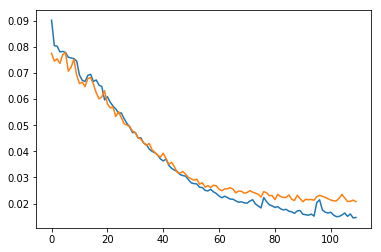

구-------름ᄋ이 거-지-이 새-작-ᄒ했어ᅥ-ᄋ요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
구름이 거지이 새작했어요.<eos>
구름이 걷히기 시작했어요.<eos>------


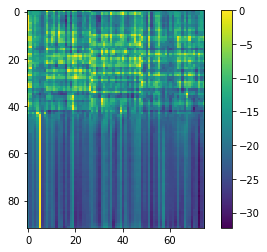

이------------------제- 다ᅡ으 모-제-를 마--치-시ᄆ면ᆫ  우-슨-하 시-이  됩니---다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이제 다으 모제를 마치시면 우슨하 시이 됩니다.<eos>
이제 다음 문제를 맞히시면, 우승하시게 됩니다.<eos>-------


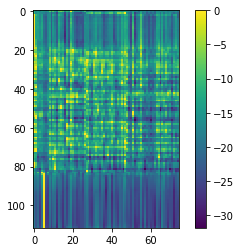

-------------------------------------------------------------------------------------------------------
09-13 15:18:56
Mean Train Loss: 0.01375787380494908
Mean Evaluation Loss: 0.02025408620505018
-------------------------------------------------------------------------------------------------------
09-13 15:19:14
Mean Train Loss: 0.014184733041554085
Mean Evaluation Loss: 0.020308971204970543
-------------------------------------------------------------------------------------------------------
09-13 15:19:32
Mean Train Loss: 0.014014614760461326
Mean Evaluation Loss: 0.021754499595889903
-------------------------------------------------------------------------------------------------------
09-13 15:19:49
Mean Train Loss: 0.013800053405347262
Mean Evaluation Loss: 0.020756174556838248
-------------------------------------------------------------------------------------------------------
09-13 15:20:07
Mean Train Loss: 0.014274358057337264
Mean Evaluation Loss: 0.021318110136652475
--

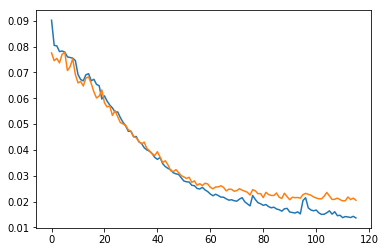

저---------------------느ᅳᆫᆫ  저--외-영-이---- 정ᆼ말 자ᄅ랑-스ᄅ러ᅥ워--ᄋ요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저는 저외영이 정말 자랑스러워요.<eos>
저는 저희 형이 정말 자랑스러워요.<eos>---------


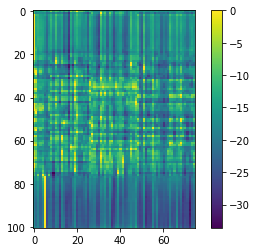

하------------ᆫ국ᆨ은  가-과-에-는ᆫ--  지-근-구-다 상에 저ᄅ이 뜰ᆯ어--했ᆻ어--요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
한국은 가과에는 지근구다 상에 저ᄅ이 뜰어했어요.<eos>
한국은 과거에는 지금보다 사계절이 뚜렷했어요.<eos>------


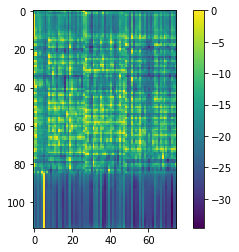

-------------------------------------------------------------------------------------------------------
09-13 15:20:44
Mean Train Loss: 0.0145234581612518
Mean Evaluation Loss: 0.020042388150106193
-------------------------------------------------------------------------------------------------------
09-13 15:21:01
Mean Train Loss: 0.01440597823895869
Mean Evaluation Loss: 0.02336246963850635
-------------------------------------------------------------------------------------------------------
09-13 15:21:20
Mean Train Loss: 0.014225249014329512
Mean Evaluation Loss: 0.02080282860403638
-------------------------------------------------------------------------------------------------------
09-13 15:21:37
Mean Train Loss: 0.013024784570059053
Mean Evaluation Loss: 0.020866969319970237
-------------------------------------------------------------------------------------------------------
09-13 15:21:55
Mean Train Loss: 0.013471656865415547
Mean Evaluation Loss: 0.02462329499390119
------

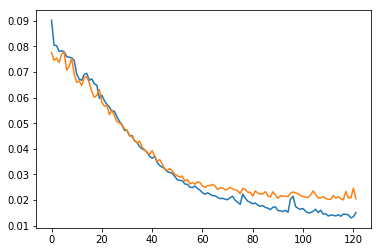

아----------니-는 어ᄆ마아ᄀᄀ 야ᅣᄃ도ᄋ있을 때-가- 제--ᆯᆯ 펴-난래  고-여--ᄋ요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아니는 어마아ᄀ 야도있을 때가 젤 펴난래 고여요.<eos>
아기는 엄마에게 안겨 있을 때가 제일 편안해 보여요.<eos>-


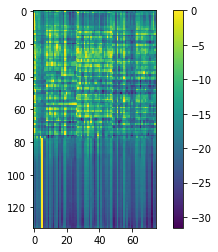

소---------------님을 아-지자ᅡ-기 위ᄋᄒ  집을  청-서 ᄒ했어ᅥᄋ요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
소님을 아지자기 위ᄋᄒ 집을 청서 했어요.<eos>
손님을 맞이하기 위해 집을 청소했어요.<eos>--


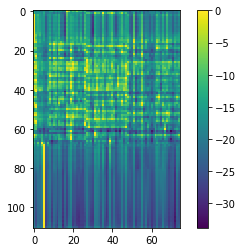

-------------------------------------------------------------------------------------------------------
09-13 15:22:33
Mean Train Loss: 0.013360607801833053
Mean Evaluation Loss: 0.020402896037429234
-------------------------------------------------------------------------------------------------------
09-13 15:22:50
Mean Train Loss: 0.012823247072535047
Mean Evaluation Loss: 0.02334494467781494
-------------------------------------------------------------------------------------------------------
09-13 15:23:08
Mean Train Loss: 0.014791262945987217
Mean Evaluation Loss: 0.01989729400463903
-------------------------------------------------------------------------------------------------------
09-13 15:23:26
Mean Train Loss: 0.013085484506076436
Mean Evaluation Loss: 0.01998309736213633
-------------------------------------------------------------------------------------------------------
09-13 15:23:45
Mean Train Loss: 0.013306663191349061
Mean Evaluation Loss: 0.02015720791348214
----

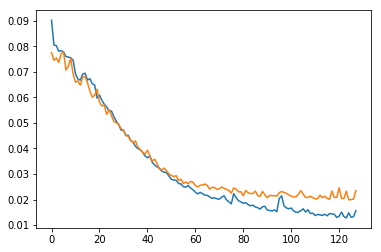

그-------------녀--ᅴ  기-스-은-- 그--년-자의  진-술--과----  이-묘-야-게  다-르---다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그녀ᅴ 기스은 그년자의 진술과 이묘야게 다르다.<eos>
그녀의 기술은 그 남자의 진술과 미묘하게 다르다.<eos>-------


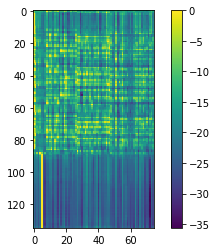

배----------ᄋᄒ---ᅵᅵ 구  ᅵᅵᆷ구-  절-반 ᄌᄌᆼᆷ-보-가-----  수-ᅩᅩ-구르ᅳᆯ 몰려 이ᅵᆻ어ᅥᄋᄋ요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
배ᄋ히 구 ᅵᆷ구 절반 ᄌᆼᆷ보가 수ᅩ구를 몰려 있어요.<eos>
대한민국 인구의 절반 정도가 수도권에 모여 있어요.<eos>-


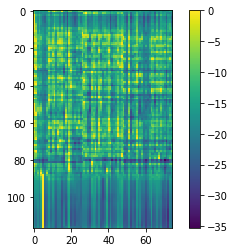

-------------------------------------------------------------------------------------------------------
09-13 15:24:21
Mean Train Loss: 0.014784314359817178
Mean Evaluation Loss: 0.02078276542442412
-------------------------------------------------------------------------------------------------------
09-13 15:24:39
Mean Train Loss: 0.013242864616604063
Mean Evaluation Loss: 0.019686211562969288
-------------------------------------------------------------------------------------------------------
09-13 15:24:57
Mean Train Loss: 0.012350844741933986
Mean Evaluation Loss: 0.020032947246516265
-------------------------------------------------------------------------------------------------------
09-13 15:25:15
Mean Train Loss: 0.01443232921788527
Mean Evaluation Loss: 0.020572387843611685
-------------------------------------------------------------------------------------------------------
09-13 15:25:33
Mean Train Loss: 0.0130978495944758
Mean Evaluation Loss: 0.0201178036417098
------

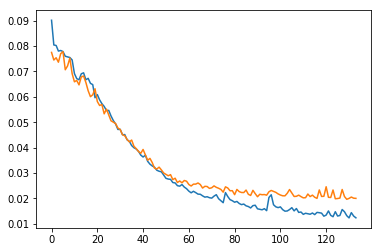

벼-------------------ᆫ이  모-몸을 들어야-하-니-  드-래-를 가-져올ᆯ-게-ᄋ요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
변이 모몸을 들어야하니 드래를 가져올게요.<eos>
벽에 구멍을 뚫어야 하니 드릴을 가져올게요.<eos>----------


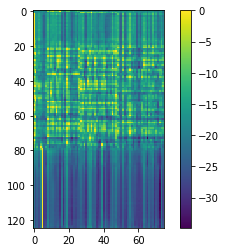

그--------------- - -쌔-----------  그 ᄋ일으ᅳᆫ  나ᄒ한테 무ᅮ이ᄋ흘 것 같---ᄋ아.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그  쌔 그 일은 나한테 무이ᄋ흘 것 같아.<eos>
글쎄, 그 일은 나한테 무리일 것 같아.<eos>----


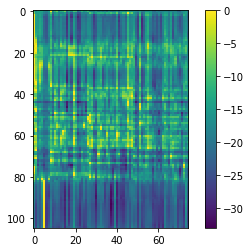

-------------------------------------------------------------------------------------------------------
09-13 15:26:09
Mean Train Loss: 0.012228502907784156
Mean Evaluation Loss: 0.019821360426900435
-------------------------------------------------------------------------------------------------------
09-13 15:26:28
Mean Train Loss: 0.011755900364303566
Mean Evaluation Loss: 0.020425844690914373
-------------------------------------------------------------------------------------------------------
09-13 15:26:46
Mean Train Loss: 0.012301963422809486
Mean Evaluation Loss: 0.020636386690874593
-------------------------------------------------------------------------------------------------------
09-13 15:27:03
Mean Train Loss: 0.012060498191931415
Mean Evaluation Loss: 0.02098970809516775
-------------------------------------------------------------------------------------------------------
09-13 15:27:21
Mean Train Loss: 0.011817434419712917
Mean Evaluation Loss: 0.020600197439019856
-

In [18]:
EPOCH = 2 * 60 * 1

# 'keyword' determines the save keyword
# Change this keyword if you want to start training a new model
keyword = 'parallel_test_threading_end_flag'

# List of loss values
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword)).tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword)).tolist()
except:
    print("Loading Failed")
    
# Load model if model weights already exists
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    preloader_train.initialize_batch(16)
    loss_list_train = list()
    
    while preloader_train.end_flag == False:
        batch = preloader_train.get_batch()
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list = batch
            pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_train.append(loss)

    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    preloader_eval.initialize_batch(16)
    loss_list_eval = list()
    
    while preloader_eval.end_flag == False:
        batch = preloader_eval.get_batch()
        if batch != None:
            tensor_input, ground_truth_, loss_mask, length_list = batch
            pred_tensor_, loss = net.test(tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_eval.append(loss)

    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))

    if ((epoch != 0) and (epoch % 6 == 0)):
        
        plt.figure()
        plt.plot(loss_history_train)
        plt.plot(loss_history_eval)
        plt.show()
        
        # index is the position of the max probility of the first batch
        # Shape of the pred_tensor: (T, B, 75)
        # Shape of the index: (T)
        _, index = pred_tensor[:, 0, :].max(-1)

        # Change index numbers to character
        sentence = tokenizer.num2word(index.view(-1))
        
        # Change list to string
        print(''.join(sentence))
        
        # Remove "blank" and overlapping characters
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        # Plot image
        # detach().cpu().numpy() transforms a tensor on gpu into a numpy matrix
        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        _, index = pred_tensor_[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        
                        
    print("-------------------------------------------------------------------------------------------------------")
    
    
    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword), loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword), loss_history_eval)